# Projet SY09 - Bigfoot

A faire :
* ajouter de Laura : carte, ACP et CAH + visualisations multivariées
* ? rempalcer abbréviation du mois par numéro de mois
* Remplacer les valeurs manquantes et refaire des étapes si besoin
* Ajouter des unités aux graphiques
* parler en pourcentage

## Import des bibiliothèques

In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as linalg

from datetime import datetime
from calendar import month_abbr, month_abbr

import plotly.express as px
import contextily

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import AgglomerativeClustering, KMeans

from utils import plot_dendrogram, scatterplot_pca

from rake_nltk import Rake

%matplotlib inline

## Chargement du jeu de données

In [2]:
# importer données du fichier csv

bigfoot = pd.read_csv("data/bigfoot.csv", sep = ",")
bigfoot

observed  \
0     I was canoeing on the Sipsey river in Alabama....   
1     Ed L. was salmon fishing with a companion in P...   
2     While attending U.R.I in the Fall of 1974,I wo...   
3     Hello, My name is Doug and though I am very re...   
4     It was May 1984. Two friends and I were up in ...   
...                                                 ...   
5016  while camping protecting other equipment befor...   
5017  I was on my way to work on a Saturday morning ...   
5018  On the twenty sixth and again on the twenty se...   
5019  I was hunting on me and my neighbor's property...   
5020  I was riding with a friend in the summer of 19...   

                                       location_details  \
0                                                   NaN   
1                     East side of Prince William Sound   
2                Great swamp area, Narragansett Indians   
3     I would rather not have exact location (listin...   
4     Logging roads north west of Yamhill, OR, about...   
...                                                 ...   
5016                                         (withheld)   
5017  Laurel, Maryland.  It was sighted off of Rt 19...   
5018  head n.on highway 441 from Orlando,then go eas...   
5019  It was on my neighbor's property in the woods ...   
5020  This happened on the Mississippi River Road in...   

                              county         state  season  \
0                     Winston County       Alabama  Summer   
1     Valdez-Chitina-Whittier County        Alaska    Fall   
2                  Washington County  Rhode Island    Fall   
3                        York County  Pennsylvania  Summer   
4                     Yamhill County        Oregon  Spring   
...                              ...           ...     ...   
5016               Rio Arriba County    New Mexico  Summer   
5017          Prince George's County      Maryland  Spring   
5018                     Lake County       Florida  Summer   
5019                    White County      Illinois    Fall   
5020                  Calhoun County      Illinois  Summer   

                                                  title  latitude  longitude  \
0                                                   NaN       NaN        NaN   
1                                                   NaN       NaN        NaN   
2     Report 6496: Bicycling student has night encou...     41.45      -71.5   
3                                                   NaN       NaN        NaN   
4                                                   NaN       NaN        NaN   
...                                                 ...       ...        ...   
5016                                                NaN       NaN        NaN   
5017                                                NaN       NaN        NaN   
5018                                                NaN       NaN        NaN   
5019                                                NaN       NaN        NaN   
5020                                                NaN       NaN        NaN   

            date   number  ... moon_phase precip_intensity  \
0            NaN  30680.0  ...        NaN              NaN   
1            NaN   1261.0  ...        NaN              NaN   
2     1974-09-20   6496.0  ...       0.16              0.0   
3            NaN   8000.0  ...        NaN              NaN   
4            NaN    703.0  ...        NaN              NaN   
...          ...      ...  ...        ...              ...   
5016         NaN  11992.0  ...        NaN              NaN   
5017         NaN   1171.0  ...        NaN              NaN   
5018         NaN  30267.0  ...        NaN              NaN   
5019         NaN  59058.0  ...        NaN              NaN   
5020         NaN  39827.0  ...        NaN              NaN   

      precip_probability  precip_type  pressure                 summary  \
0                    NaN          NaN       NaN                     NaN   
1                    NaN    

In [3]:
# informations avant traitements

bigfoot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5021 entries, 0 to 5020
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   observed            4983 non-null   object 
 1   location_details    4261 non-null   object 
 2   county              5021 non-null   object 
 3   state               5021 non-null   object 
 4   season              5021 non-null   object 
 5   title               4045 non-null   object 
 6   latitude            4045 non-null   float64
 7   longitude           4045 non-null   float64
 8   date                4045 non-null   object 
 9   number              5021 non-null   float64
 10  classification      5021 non-null   object 
 11  geohash             4045 non-null   object 
 12  temperature_high    3338 non-null   float64
 13  temperature_mid     3186 non-null   float64
 14  temperature_low     3189 non-null   float64
 15  dew_point           3373 non-null   float64
 16  humidi

On a donc les informations suivantes :

| Variables          | Description                                                                                                                                                                                                                                                                                            |
|:--------------------|:--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| observed           | Témoignage textuel.                                                                                                                                                                                                                                                                                    |
| location_details   | Texte détaillant le lieu où le bigfoot aurait été repéré.                                                                                                                                                                                                                                              |
| county             | Comté. Division plus petite qu'un état mais plus grand qu'une ville.                                                                                                                                                                                                                                   |
| state              | Etat des Etats-Unis.                                                                                                                                                                                                                                                                                   |
| season             | Les 4 saisons.                                                                                                                                                                                                                                                                                         |
| title              | Format “Report [numéro] : [titre]”                                                                                                                                                                                                                                                                     |
| latitude           | Latitude (localisation géographique).                                                                                                                                                                                                                                                                  |
| longitude          | Longitude (localisation géographique).                                                                                                                                                                                                                                                                 |
| date               | Date (donnée temporelle).                                                                                                                                                                                                                                                                              |
| number             | Numéro de rapport.                                                                                                                                                                                                                                                                                     |
| classification     | 3 valeurs possibles : “Class A”, “Class B”, “Class C”. Class A : a croisé le Bigfoot sans erreur d'interprétation. Class B : a possiblement croisé le Bigfoot. Class C : témoignage de faible fiabilité, peu de sources (non pris en compte car fort potentiel que ces personnes n'aient pas vu le big foot) |
| geohash            | Redondance avec les variables latitude et longitude.                                                                                                                                                                                                                                                   |
| temperature_high   | Température haute.                                                                                                                                                                                                                                                                                     |
| temperature_mid    | Température moyenne.                                                                                                                                                                                                                                                                                   |
| temperature_low    | Température basse.                                                                                                                                                                                                                                                                                     |
| dew_point          | Point de rosée. Est une température. Se détermine en fonction de la température et de l'humidité.                                                                                                                                                                                                                                                                |
| humidity           | Taux d'humidité.                                                                                                                                                                                                                                                                                       |
| cloud_cover        | Taux de couverture nuageuse.                                                                                                                                                                                                                                                                           |
| moon_phase         | Phase de la lune telle que : 0 à 0.25 pour le 1er croissant, 0.25 pour le 1er quartier, 0.25 à 0.5 pour la lune gibbeuse croissante, 0.5 pour la pleine lune, 0.5 à 0.75 pour la lune gibbeuse décroissante, 0.75 pour le dernier quartier et 0.75 à 1 pour le dernier croissant.                                                                  |
| precip_intensity   | Intensité de la pluie en hauteur d'eau tombée sur le sol.                                                                                                                                                                                                                                              |
| precip_probability | Probabilité de pluie.                                                                                                                                                                                                                                                                                  |
| precip_type        | Type de précipitation.                                                                                                                                                                                                                                                                                 |
| pressure           | Pression atmosphérique.                                                                                                                                                                                                                                                                                |
| summary            | Texte résumant les conditions météorologiques.                                                                                                                                                                                                                                                         |
| uv_index           | Indice UV.                                                                                                                                                                                                                                                                                             |
| visibility         | Visibilité. Est une distance.                                                                                                                                                                                                                                                                          |
| wind_bearing       | Différent de la direction du vent. Représente la direction vers laquelle un objet est déplacé par le vent.                                                                                                                                                                                             |
| wind_speed         | Vitesse du vent.                                                                                                                                                                                                                                                                                       |

A noter que le climat change d'un état à un autre. En floride il fait plus chaud que dans le nord du pays.

### Mise en forme du jeu de données
#### Ajout et suppression de colonnes

In [4]:
# ajoute des colonnes jour, mois, année
# A faire avant que "date" ne soit convertie au format datetime64[ns]

year = bigfoot['date'].copy()
month = bigfoot['date'].copy()
day = bigfoot['date'].copy()

for i in range(bigfoot['date'].size):
    d = bigfoot['date'][i]
    if str(d) != "nan":
        d_datetime = datetime.strptime(str(d),'%Y-%m-%d')
        year[i] = d_datetime.year
        month[i] = datetime.strptime(str(d_datetime.month), "%m").strftime("%b") # nom abbrégé du mois
        day[i] = d_datetime.day

bigfoot = bigfoot.assign(year = year)
bigfoot = bigfoot.assign(month = month)
bigfoot = bigfoot.assign(day = day)

# suppression de la colonne "geohash"

bigfoot.drop(columns="geohash", inplace=True)

#### Conversion d'unité et mise en forme des données

In [5]:
# temperature_high : fahrenheit en celsius
# temperature_mid : fahrenheit en celsius
# temperature_low : fahrenheit en celsius
# dew_point : fahrenheit en celsius

# wind_speed : miles par heure en kilomètre par heure

# precip_intensity : inch en cm

# visibility : miles en kilomètre

bigfoot = bigfoot.assign(
    temperature_high = (bigfoot.temperature_high - 32) * 5 / 9,
    temperature_mid = (bigfoot.temperature_mid - 32) * 5 / 9,
    temperature_low = (bigfoot.temperature_low - 32) * 5 / 9,
    dew_point = (bigfoot.dew_point - 32) * 5 / 9,
    
    wind_speed = bigfoot.wind_speed * 1.609344,
    
    precip_intensity = bigfoot.precip_intensity * 2.54,
    
    visibility = bigfoot.visibility * 1.609344
)

# pour le "titre" garde la partie [titre] du format inital “Report [numéro] : [titre]”

bigfoot = bigfoot.assign(
    title = bigfoot.title.str.replace(r'^Report \d*: ', '')
)

/tmp/ipykernel_11189/1321290715.py:28: FutureWarning: The default value of regex will change from True to False in a future version.
  title = bigfoot.title.str.replace(r'^Report \d*: ', '')


#### Conversion des types

In [6]:
# dictionnaire des états des Etats-Unis et leur abbrévation

us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
}

# Liste des mois en abbrégé

months = [
    "Jan",
    "Feb",
    "Mar",
    "Apr",
    "May",
    "Jun",        
    "Jul",
    "Aug",
    "Sep",
    "Oct",
    "Nov",
    "Dec"]

In [7]:
# variables catégorielles

# county
bigfoot.county = pd.Categorical(bigfoot.county)

# state
bigfoot.state = pd.Categorical(bigfoot.state, categories=us_state_to_abbrev.keys())

# season
bigfoot.season = bigfoot.season.replace("Unknown", np.nan)
bigfoot.season = pd.Categorical(bigfoot.season, categories=["Winter", "Spring", "Summer", "Fall"], ordered=True)

# classification
bigfoot.classification = bigfoot.classification.replace("Class A", "A")
bigfoot.classification = bigfoot.classification.replace("Class B", "B")
bigfoot.classification = bigfoot.classification.replace("Class C", "C")
bigfoot.classification = pd.Categorical(bigfoot.classification, categories=["A", "B", "C"], ordered=True)

# precip_type
bigfoot.precip_type = pd.Categorical(bigfoot.precip_type, categories=["rain", "snow"])

# mois
bigfoot.month = pd.Categorical(bigfoot.month, categories=months, ordered=True)

In [8]:
# types des variables

# Attention! Conséquence, variables catégorielles ont des valeurs <NA> à la place de NaN.

bigfoot.observed = bigfoot.observed.astype('string')
bigfoot.location_details = bigfoot.location_details.astype('string')
bigfoot.title = bigfoot.title.astype('string')
bigfoot.summary = bigfoot.summary.astype('string')


bigfoot.uv_index = bigfoot.uv_index.astype('Int64')
bigfoot.number = bigfoot.number.astype('Int64')

bigfoot.day = bigfoot.day.astype('Int64')
bigfoot.year = bigfoot.year.astype('Int64')

# Attention! Conséquence, date a des valeurs NaT à la place de NaN.
bigfoot.date = bigfoot.date.astype("datetime64[ns]")

In [9]:
# vérification des modifications

bigfoot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5021 entries, 0 to 5020
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   observed            4983 non-null   string        
 1   location_details    4261 non-null   string        
 2   county              5021 non-null   category      
 3   state               5021 non-null   category      
 4   season              4929 non-null   category      
 5   title               4045 non-null   string        
 6   latitude            4045 non-null   float64       
 7   longitude           4045 non-null   float64       
 8   date                4045 non-null   datetime64[ns]
 9   number              5021 non-null   Int64         
 10  classification      5021 non-null   category      
 11  temperature_high    3338 non-null   float64       
 12  temperature_mid     3186 non-null   float64       
 13  temperature_low     3189 non-null   float64     

In [10]:
# vérification des modifications

# bigfoot

#### Sauvegarder le jeu de données mis en forme

In [11]:
# attention : si utilisé par la suite, refaire toute les manipulations de changement de type car bigfoot.info() ne renverra pas ce qui a été obtenu juste avant

bigfoot.to_csv("data/bigfoot_after_manipulation.csv", index=False)

## Exploration des données

### Exploration univariée

In [12]:
# valeurs toujours indiquées : county, state, season, number, classification
# quasiment toujours données : observed, location_details
# quasiment toujours données (ensemble): title, longitude, latitude, date (donc day, month, year)

total = bigfoot.isna().sum().sort_values(ascending=False)
percent = (bigfoot.isna().sum()/bigfoot.isna().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

Total   Percent
precip_type          3298  0.656841
pressure             2402  0.478391
precip_probability   2311  0.460267
precip_intensity     2309  0.459869
visibility           1972  0.392750
cloud_cover          1937  0.385780
temperature_mid      1835  0.365465
temperature_low      1832  0.364868
temperature_high     1683  0.335192
summary              1655  0.329616
dew_point            1648  0.328221
humidity             1648  0.328221
wind_bearing         1634  0.325433
wind_speed           1632  0.325035
uv_index             1629  0.324437
moon_phase           1625  0.323641
year                  976  0.194384
month                 976  0.194384
day                   976  0.194384
date                  976  0.194384
longitude             976  0.194384
latitude              976  0.194384
title                 976  0.194384
location_details      760  0.151364
season                 92  0.018323
observed               38  0.007568
classification          0  0.000000
number                  0  0.000000
state                   0  0.000000
county                  0  0.000000

In [13]:
# variables numériques

bigfoot.describe()

latitude    longitude        number  temperature_high  \
count  4045.000000  4045.000000        5021.0       3338.000000   
mean     39.363271   -97.423304  21520.234814         19.509830   
std       5.684022    16.727556  19259.146267          9.879105   
min      25.141000  -167.131000          60.0        -18.122222   
25%      35.345720  -117.057900        4595.0         12.855556   
50%      39.304500   -91.767330       15473.0         21.097222   
75%      43.931100   -83.069770       33979.0         27.275000   
max      64.891390   -68.228300       71997.0         41.394444   

       temperature_mid  temperature_low    dew_point     humidity  \
count      3186.000000      3189.000000  3373.000000  3373.000000   
mean         14.357432         9.243760     7.907463     0.705672   
std           9.109215         8.857676     9.135823     0.160626   
min         -22.475000       -30.433333   -24.005556     0.080000   
25%           8.204167         3.055556     1.538889     0.620000   
50%          15.200000         9.666667     8.161111     0.730000   
75%          21.322222        15.922222    15.000000     0.820000   
max          34.461111        29.077778    25.222222     1.000000   

       cloud_cover   moon_phase  precip_intensity  precip_probability  \
count  3084.000000  3396.000000       2712.000000         2710.000000   
mean      0.438982     0.497968          0.014499            0.295771   
std       0.332981     0.288318          0.127324            0.418053   
min       0.000000     0.000000          0.000000            0.000000   
25%       0.120000     0.250000          0.000000            0.000000   
50%       0.400000     0.490000          0.000000            0.000000   
75%       0.730000     0.750000          0.003810            0.730000   
max       1.000000     1.000000          5.255260            1.000000   

          pressure  uv_index   visibility  wind_bearing   wind_speed  \
count  2619.000000    3392.0  3049.000000   3387.000000  3389.000000   
mean   1017.081184  5.161262    13.667267    196.572483     6.221855   
std       6.144359  3.136283     3.315492     96.375443     5.285835   
min     980.340000       0.0     1.190915      0.000000     0.000000   
25%    1013.420000       3.0    12.327575    128.000000     2.156521   
50%    1016.960000       5.0    15.209910    203.000000     4.715378   
75%    1020.635000       8.0    16.093440    273.000000     8.947953   
max    1042.410000      13.0    16.093440    359.000000    38.527695   

              year        day  
count       4045.0     4045.0  
mean   1998.917429  14.344623  
std      14.628472   8.583989  
min         1869.0        1.0  
25%         1990.0        8.0  
50%         2003.0       15.0  
75%         2009.0       20.0  
max         2021.0       31.0

On remarque que :
* Les températures sont tempérées. Les médianes pour les température basses, moyennes et élevées sont de 9,7°C, 15,2°C et de 21°C.
* Le taux d'humidité pour le premier quartile est à 62%, la médiane à 73% et le troisième quartile à 82%. D'après http://www.usa.com/rank/us--average-humidity--state-rank.htm , l'état avec l'humidité moyenne la plus basse prend une valeur de 71% et la plus haute à 82%. 
* Il y a peu de précipitations et si il y en a elle est de faible intensité.

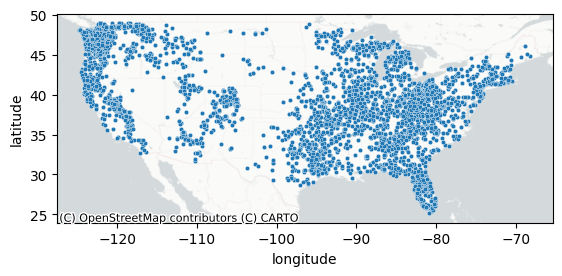

In [72]:
# longitude > -130 donc enlève Alaska et 3 autres points
ax = sns.scatterplot(x=bigfoot['longitude'][bigfoot['longitude'] > -130], y='latitude', s=10, data=bigfoot)
contextily.add_basemap(
    ax,
    crs="EPSG:4326",
    source=contextily.providers.CartoDB.PositronNoLabels,
);

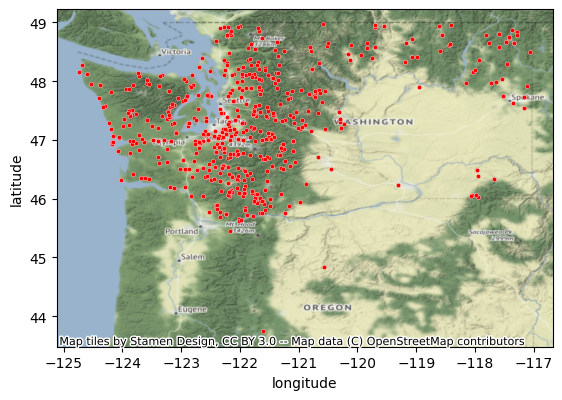

In [73]:
# Generate scatter plot
ax = sns.scatterplot(x=bigfoot['longitude'][(bigfoot['state'] == "Washington") & (bigfoot['longitude'] > -130)], y='latitude', s=10, data=bigfoot, c="red")
contextily.add_basemap(
    ax,
    crs="EPSG:4326",
);

In [74]:
# Generate scatter plot
ax = sns.scatterplot(x=bigfoot['longitude'][(bigfoot['state'] == "California") & (bigfoot['longitude'] > -130)], y='latitude', s=10, data=bigfoot, c="red")
contextily.add_basemap(
    ax,
    crs="EPSG:4326",
);

Comme c'était prévisible, les points sont situés dans les régions montagneuses.

In [15]:
# Les témoignages remontent à 1869 mais commencent à être notables dans les années 1960,puis une tendance vers la fin des années 70 et début des années 80.
# Puis un léger déclin. Dans les années 90 il y eut un net engouement jusqu'à 2004, 
# l'année avec le plus de témoignages et s'ensuit un déclin jusqu'à de nos jours en 2021.

plt.figure(figsize=(20,4))
ax = sns.countplot(x=bigfoot.year[bigfoot.year != np.NaN])
ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha="right")
plt.show()

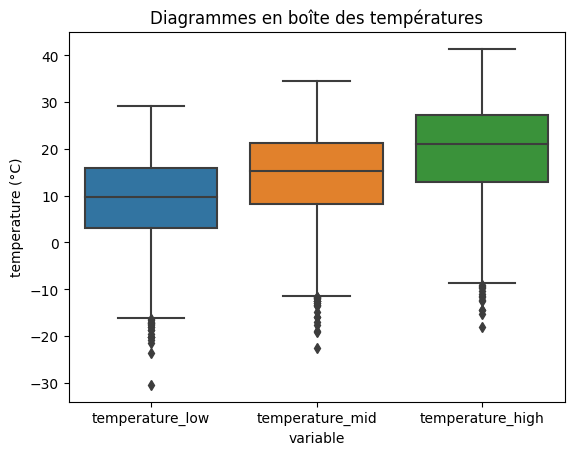

In [16]:
df = pd.DataFrame(data=bigfoot, columns=["temperature_low", "temperature_mid", "temperature_high"])
sns.boxplot(x="variable", y="value", data=pd.melt(df))
plt.ylabel("temperature (°C)")
plt.title("Diagrammes en boîte des températures")
plt.show()

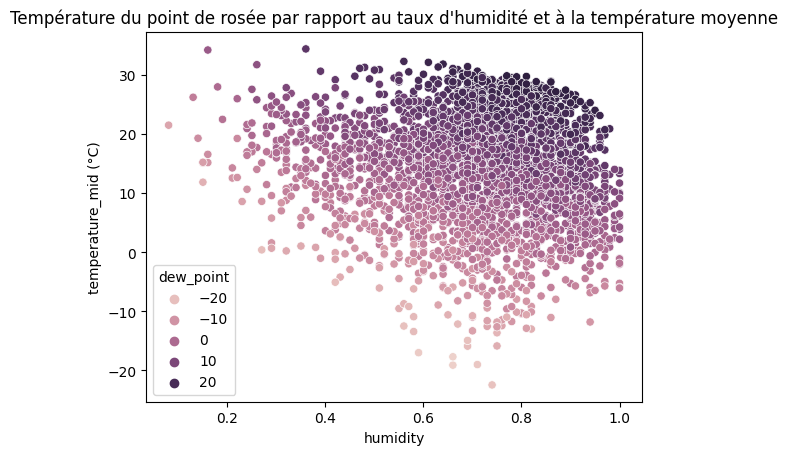

In [17]:
# pour montrer que "dew_point" dépend de "humidity" et de "temperature"

sns.scatterplot(x="humidity", y= "temperature_mid", hue = "dew_point", data = bigfoot)
plt.xlabel("humidity")
plt.ylabel("temperature_mid (°C)")
plt.title("Température du point de rosée par rapport au taux d'humidité et à la température moyenne")
plt.show()

<AxesSubplot: title={'center': 'wind_speed (km/h)'}, xlabel='wind_speed'>

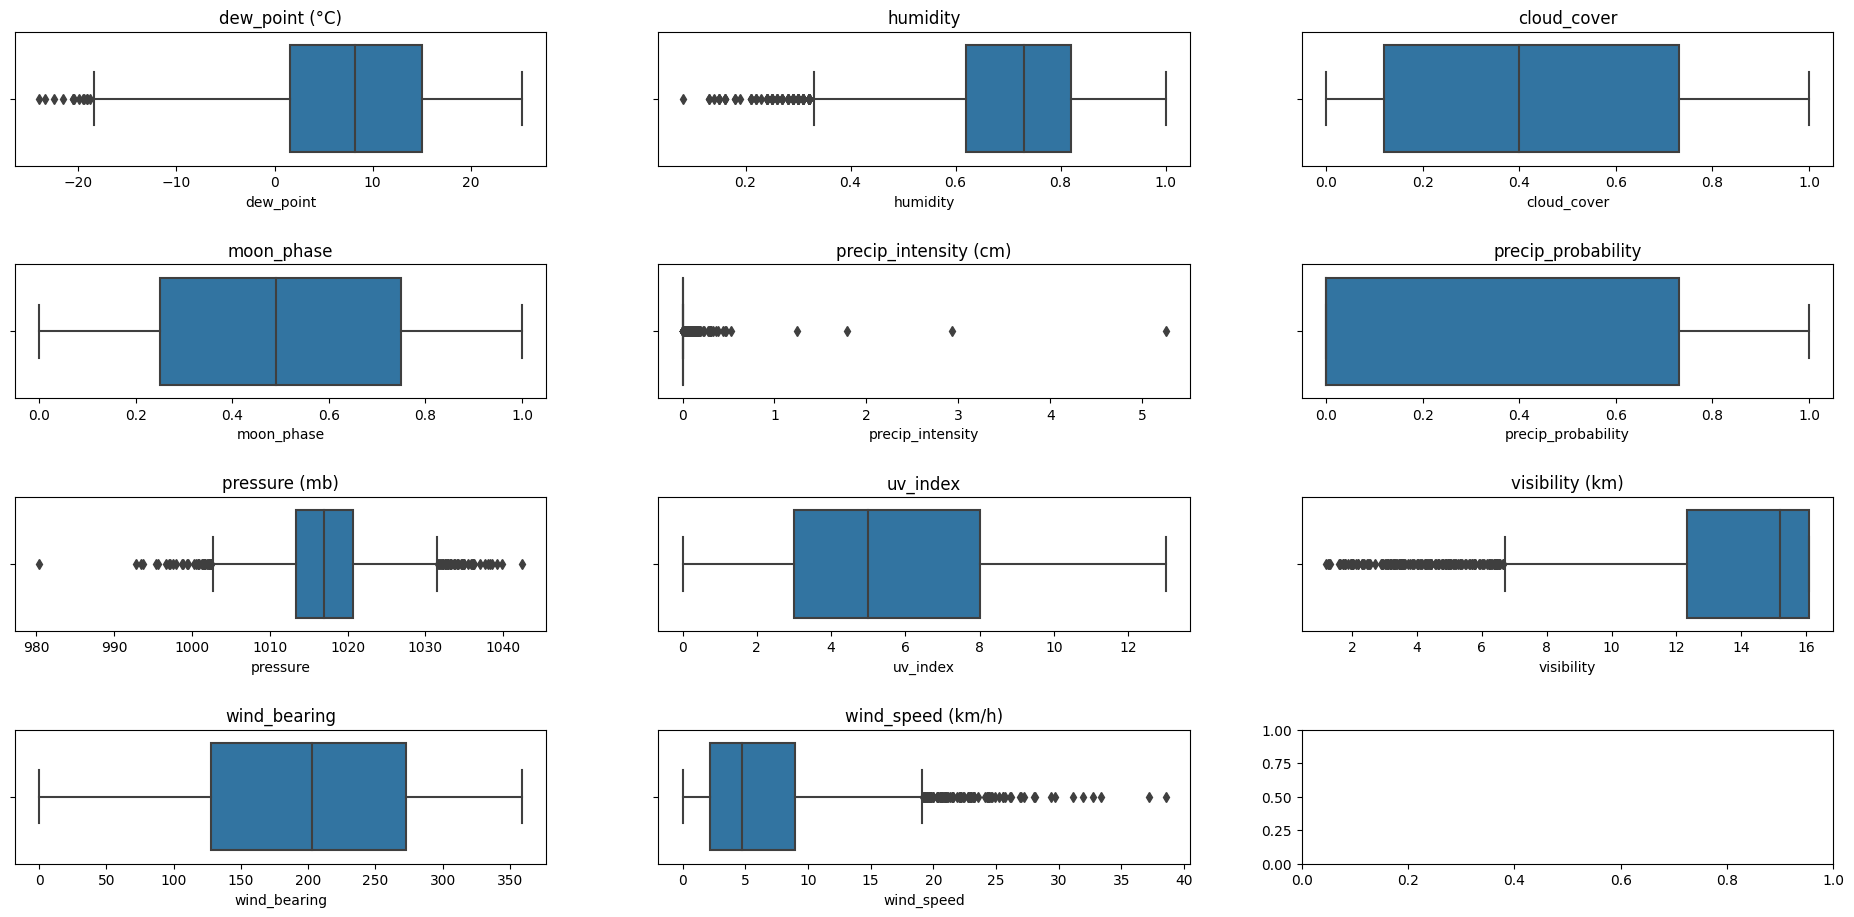

In [18]:
fig, axes = plt.subplots(nrows = 4, ncols = 3, figsize=(20, 10))
fig.tight_layout(pad=5.0)

axes[0, 0].set_title("dew_point (°C)")
sns.boxplot(ax=axes[0, 0], x="dew_point", data = bigfoot)

axes[0, 1].set_title("humidity")
sns.boxplot(ax=axes[0, 1], x="humidity", data = bigfoot)

axes[0, 2].set_title("cloud_cover")
sns.boxplot(ax=axes[0, 2], x="cloud_cover", data = bigfoot)

axes[1, 0].set_title("moon_phase")
sns.boxplot(ax=axes[1, 0], x="moon_phase", data = bigfoot)

axes[1, 1].set_title("precip_intensity (cm)")
sns.boxplot(ax=axes[1, 1], x="precip_intensity", data = bigfoot)

axes[1, 2].set_title("precip_probability")
sns.boxplot(ax=axes[1, 2], x="precip_probability", data = bigfoot)

axes[2, 0].set_title("pressure (mb)")
sns.boxplot(ax=axes[2, 0], x="pressure", data = bigfoot)

axes[2, 1].set_title("uv_index")
sns.boxplot(ax=axes[2, 1], x="uv_index", data = bigfoot)

axes[2, 2].set_title("visibility (km)")
sns.boxplot(ax=axes[2, 2], x="visibility", data = bigfoot)

axes[3, 0].set_title("wind_bearing")
sns.boxplot(ax=axes[3, 0], x="wind_bearing", data = bigfoot)

axes[3, 1].set_title("wind_speed (km/h)")
sns.boxplot(ax=axes[3, 1], x="wind_speed", data = bigfoot)


On remarque que : 
* Confirmation que s'il y a des précipitations, celles-ci sont généralement très faibles.
* L'index uv est moyen, avec une tendance avec des valeurs faibles à moyenne.

Ci-dessous, des comparaisons entre diagrammes en boîte et histogramme pour une meilleure interprétation.

<AxesSubplot: title={'center': 'Histogramme'}, xlabel='cloud_cover', ylabel='Count'>

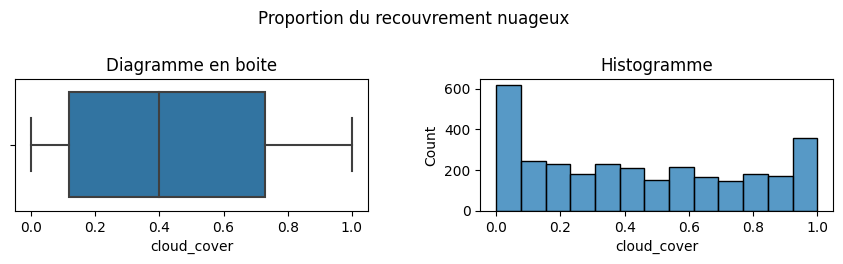

In [19]:
# Il peut ne pas avoir du tout de nuage ou en avoir.

fig, axes = plt.subplots(ncols = 2, figsize=(10, 3))
fig.tight_layout(pad=5.0)
fig.suptitle("Proportion du recouvrement nuageux")

axes[0].set_title("Diagramme en boite")
sns.boxplot(ax=axes[0], x="cloud_cover", data = bigfoot)

axes[1].set_title("Histogramme")
sns.histplot(ax=axes[1], x="cloud_cover", data = bigfoot)

In [20]:
# La phase de la lune importe peu.

fig, axes = plt.subplots(ncols = 2, figsize=(10, 3))
fig.tight_layout(pad=5.0)
fig.suptitle("Phases de la lune")

axes[0].set_title("Diagramme en boite")
sns.boxplot(ax=axes[0], x="moon_phase", data = bigfoot)

axes[1].set_title("Histogramme")
sns.histplot(ax=axes[1], x="moon_phase", data = bigfoot)

<AxesSubplot: title={'center': 'Histogramme'}, xlabel='moon_phase', ylabel='Count'>

In [21]:
# En général, il ne pleut pas.

fig, axes = plt.subplots(ncols = 2, figsize=(10, 3))
fig.tight_layout(pad=5.0)
fig.suptitle("Probabilité qu'il pleuve")

axes[0].set_title("Diagramme en boite")
sns.boxplot(ax=axes[0], x="precip_probability", data = bigfoot)

axes[1].set_title("Histogramme")
sns.histplot(ax=axes[1], x="precip_probability", data = bigfoot)

<AxesSubplot: title={'center': 'Histogramme'}, xlabel='precip_probability', ylabel='Count'>

<AxesSubplot: title={'center': 'Histogramme'}, xlabel='pressure', ylabel='Count'>

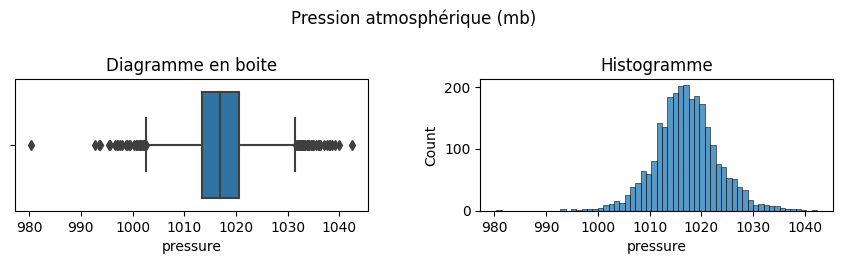

In [22]:
# La distribution est en forme de cloche, plutôt symétrique, c'est caractérstique d'une mesure naturelle.

fig, axes = plt.subplots(ncols = 2, figsize=(10, 3))
fig.tight_layout(pad=5.0)
fig.suptitle("Pression atmosphérique (mb)")

axes[0].set_title("Diagramme en boite")
sns.boxplot(ax=axes[0], x="pressure", data = bigfoot)

axes[1].set_title("Histogramme")
sns.histplot(ax=axes[1], x="pressure", data = bigfoot)

<AxesSubplot: title={'center': 'Densité de probabilité'}, xlabel='visibility', ylabel='Density'>

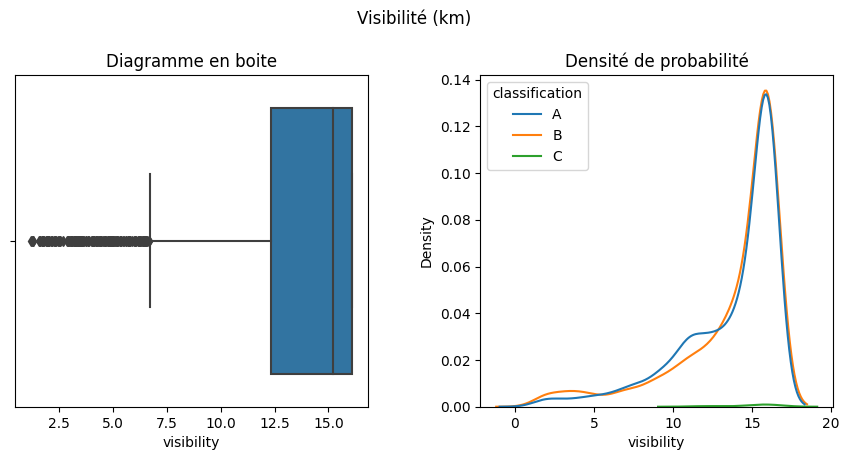

In [23]:
# A très bonne visibilité, class B est à niveau quasiment égal avec la class A et peut même surpasser.
# Il existe des témoignages à moyennes et mauvaise visibilité même s'ils sont moins nombreux. 
# A noter que pour une mauvaise visibilité, il y a tout de même des class A

fig, axes = plt.subplots(ncols = 2, figsize=(10, 5))
fig.tight_layout(pad=5.0)
fig.suptitle("Visibilité (km)")

axes[0].set_title("Diagramme en boite")
sns.boxplot(ax=axes[0], x="visibility", data = bigfoot)

axes[1].set_title("Densité de probabilité")
sns.kdeplot(data=bigfoot, x="visibility", hue="classification")

<AxesSubplot: title={'center': 'Histogramme'}, xlabel='wind_bearing', ylabel='Count'>

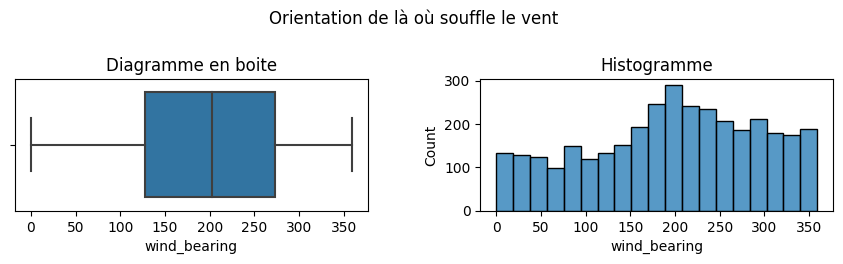

In [24]:
# Plutôt un vent du sud-ouest (environ 200°), moins un vent du nord-est (environ 45°)

fig, axes = plt.subplots(ncols = 2, figsize=(10, 3))
fig.tight_layout(pad=5.0)
fig.suptitle("Orientation de là où souffle le vent")

axes[0].set_title("Diagramme en boite")
sns.boxplot(ax=axes[0], x="wind_bearing", data = bigfoot)

axes[1].set_title("Histogramme")
sns.histplot(ax=axes[1], x="wind_bearing", data = bigfoot)

<AxesSubplot: title={'center': 'Histogramme'}, xlabel='wind_speed', ylabel='Count'>

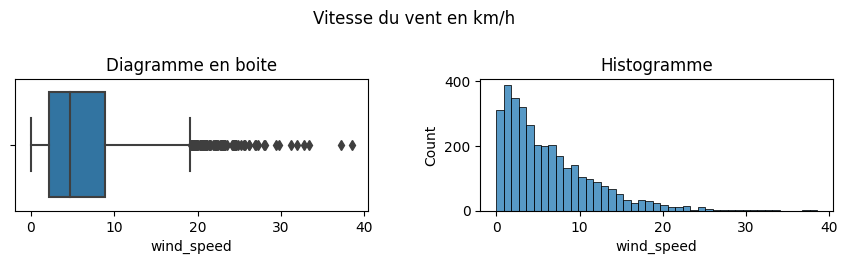

In [25]:
# Globalement un peu de vent.

fig, axes = plt.subplots(ncols = 2, figsize=(10, 3))
fig.tight_layout(pad=5.0)
fig.suptitle("Vitesse du vent en km/h")

axes[0].set_title("Diagramme en boite")
sns.boxplot(ax=axes[0], x="wind_speed", data = bigfoot)

axes[1].set_title("Histogramme")
sns.histplot(ax=axes[1], x="wind_speed", data = bigfoot)

In [26]:
# variables catégorielles

bigfoot.describe(include = "category")

county       state  season classification precip_type month
count            5021        5021    4929           5021        1723  4045
unique           1037          49       4              3           2    12
top     Pierce County  Washington  Summer              B        rain   Oct
freq               76         601    1867           2510        1562   545

In [27]:
"""
class A, class B, class C : class A et B assez équilibrées (2481 et 2510, et 30)

class A = a vu le big foot sans erreur d'interprétation
class B = possiblement
class C = témoignage de faible fiabilité, peu de sources (non pris en compte pcq fort potentiel que ces personnes n'aient pas vu le big foot)
"""

bigfoot['classification'].value_counts()

B    2510
A    2481
C      30
Name: classification, dtype: int64

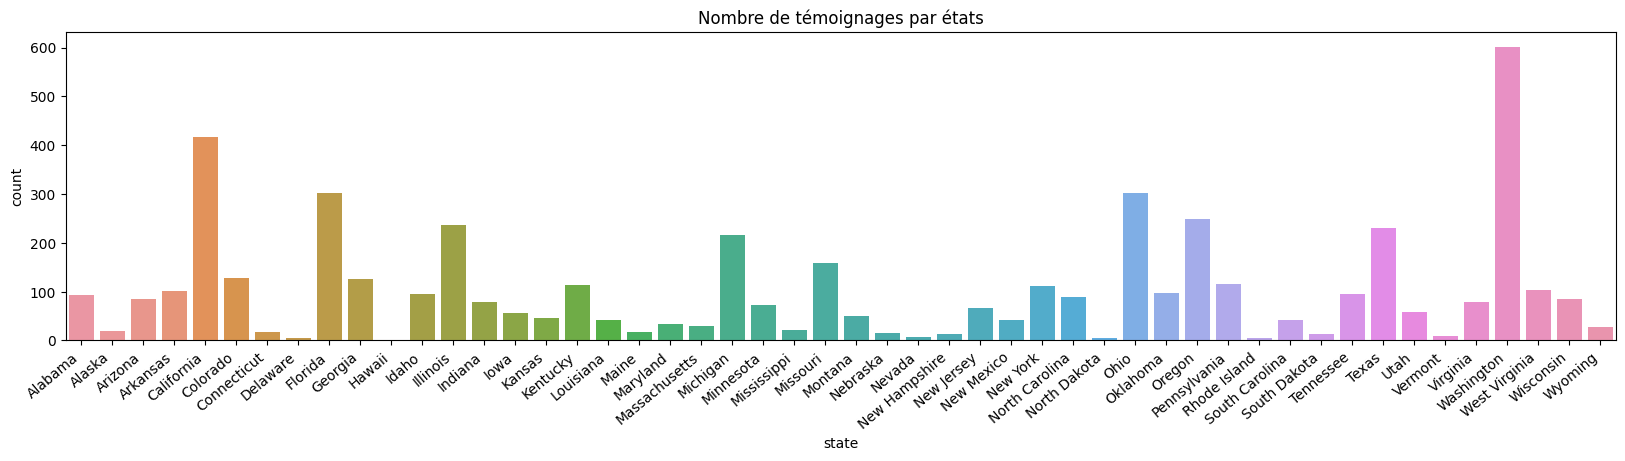

In [28]:
plt.figure(figsize=(20,4))
ax = sns.countplot(x='state', data=bigfoot)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.title("Nombre de témoignages par états")
plt.show()

In [29]:
states = pd.DataFrame(bigfoot.state.value_counts()).reset_index()
states.columns = ['state', 'count']
states = states.assign(
    code=states.state.replace(us_state_to_abbrev)
)

px.choropleth(
    states,
    locations='code',
    locationmode="USA-states",
    scope="usa",
    color="count",
    color_continuous_scale="Reds",
    title="Nombre de témoignages par états"
)

In [ ]:
# voir pourquoi on a enlevé les "unknown" pour les saisons car il y en a relativement peu

bigfoot['season'].value_counts()

In [ ]:
plt.figure(figsize=(4,3))
sns.countplot(x='season', data=bigfoot)
plt.title("Nombre de témoignages par saison")
plt.show()

In [ ]:
# les précipitations sont en général de la pluie mais il se peut que ce soit de la neige

plt.figure(figsize=(4,3))
sns.histplot(x='precip_type', data=bigfoot)
plt.title("Type de précipitations")
plt.show()

In [ ]:
# variables textuelles

bigfoot.describe(include = "string")

In [ ]:
# remarque :  été et pic en octobre (Halloween ?)

plt.figure(figsize=(5, 3))
sns.countplot(x = 'month', data=bigfoot)
plt.show()

In [ ]:
# Pour afficher toutes les valeurs prises par toutes les variables

"""
for var in bigfoot.columns:
    print(var + " count : \n" + str(bigfoot[var].value_counts()) + "\n")
"""

In [ ]:
# 5 premiers éléments les plus nombreux par variables

for var in ["state", "county", "summary", "day"]:
    print(var + " count : \n\n" + str(bigfoot[var].value_counts()[:5]) + "\n")

On remarque que :
* Les états avec le plus de témoignages sont Washington, California, Ohio, Florida.
* Le résumé météo est le plus souvent "Clear throughout the day", suivis de résumé citant des nuages.
* Hypothèse que le 1er et le 15ème du mois (milieu du mois) sont des jours par défaut

### Exploration multivariée

In [ ]:
features = [
        "latitude",
        "longitude",
        "temperature_high",
        "temperature_mid",
        "temperature_low",
        "dew_point",
        "humidity",
        "cloud_cover",
        "moon_phase",
        "precip_intensity",
        "precip_probability",
        "pressure",
        "visibility",
        "wind_bearing",
        "wind_speed",
        # "uv_index",
        # "day",
        # "month",
        # "year",
        # "season"
    ]

In [ ]:
corr = bigfoot[features].corr()
sns.heatmap(corr)

Corrélations positives:
* cloud_cover-humidity-precip_probability
* temperature_mid_deg-temperature_high_deg-temperature_low_deg-dew_point

#### Exploration class A et B

In [ ]:
# en fonction des saisons, sensiblement la même proportion de class A et B

plt.figure(figsize=(4,3))
sns.countplot(x='season', hue='classification', data=bigfoot)
plt.show()

In [ ]:
# mais plus en détail, en fonction des mois, il y a plus de class A au début de l'été (juin, juillet) et en début d'hiver (novembre, décembre).
# Plus de class B au milieu du printemps (avril, mai) et del'été (août).

plt.figure(figsize=(8, 3))
sns.countplot(x = 'month', hue='classification', order = months, data=bigfoot)
plt.show()

In [ ]:
# en fonction des états plus de class A que B
# todo comparer proportions

plt.figure(figsize=(20,4))
ax = sns.countplot(x='state', hue ='classification', data=bigfoot)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

Dans l'état de Wahshington et Californie, les deux état avec le plus de témoignanges, il y a nettement plus de class B que de class A. Cette différence de proportion est significativement plus importante que dans les autres états. Cela se retrouve aussi en Arizona, dans le Michigan, dans l'état de  New-York, l'Oregon et le Wisconsin.

Les états avec nettement plus de class A sont entre autres l'Alabama, le Kentuckt, le Missouri, l'Ohio, le Texas.

### Analyse textuelle (à refaire)

In [ ]:
rake = Rake(max_length=2, include_repeated_phrases=False)

#rake.extract_keywords_from_text("test")
rake.extract_keywords_from_text(np.stack(bigfoot['observed'])[0])

rake.get_ranked_phrases_with_scores()

#rake.get_word_degrees()

## ACP (Analyse en Composantes Principales) TEST A REFAIRE

prendre en compte jour, mois, saison en les codants avec une valeur numérique.

In [ ]:
# bigfoot_nb.month = bigfoot_nb.month.map({k: v + 1 for v, k in enumerate(months)})
# bigfoot_nb.season = bigfoot_nb.season.map({"Winter": 1, "Spring": 2, "Summer": 3, "Fall": 4})

bigfoot_acp = bigfoot.dropna(subset=features)

bigfoot_acp["state"] = np.where(bigfoot_acp["state"].isin(["Washington", "California", "Ohio", "Florida", "Oregon"]), bigfoot_acp["state"], "Other")

bigfoot_acp[features].info()

In [ ]:
def fill_missing(data):
    imp = SimpleImputer(missing_values=np.nan, strategy='mean')
    imp.fit(data)
    return imp.transform(data)

In [ ]:
def scale(data):
    scaler = StandardScaler()
    scaler.fit(data)
    return scaler.transform(data)

In [ ]:
bigfoot_norm = pd.DataFrame(scale(bigfoot_acp[features]), columns=features)

In [ ]:
cls = PCA()
pcs = cls.fit_transform(bigfoot_norm)
plt.bar(range(cls.components_.shape[0]), cls.explained_variance_ratio_)
plt.show()

In [ ]:
eig = pd.DataFrame(
    {
        "Dimension" : ["Dim" + str(x + 1) for x in range(cls.explained_variance_.size)], 
        "Variance expliquée" : cls.explained_variance_,
        "% variance expliquée" : np.round(cls.explained_variance_ratio_ * 100),
        "% cum. var. expliquée" : np.round(np.cumsum(cls.explained_variance_ratio_) * 100)
    }
)
eig

In [ ]:
plt.figure(figsize=(20,8))
df_X = pd.DataFrame(pcs, columns=[f"PC{i+1}" for i in range(cls.components_.shape[0])])
# sns.scatterplot(x="PC1", y="PC2", hue=bigfoot.classification, data=df_X) # pas le même résultat que la ligne du dessous : lequel prendre ?
sns.scatterplot(x="PC1", y="PC2", hue=bigfoot_acp.classification, data=df_X)
plt.title("Premier plan factoriel")
plt.show()

In [ ]:
n = bigfoot_norm.shape[0] # nb individus
p = bigfoot_norm.shape[1] # nb variables
eigval = (n-1) / n * cls.explained_variance_ # valeurs propres
sqrt_eigval = np.sqrt(eigval) # racine carrée des valeurs propres
corvar = np.zeros((p,p)) # matrice vide pour avoir les coordonnées
for k in range(p):
    corvar[:,k] = cls.components_[k,:] * sqrt_eigval[k]
# on modifie pour avoir un dataframe
coordvar = pd.DataFrame({'id': features, 'COR_1': corvar[:,0], 'COR_2': corvar[:,1]})
coordvar

In [ ]:
# Création d'une figure vide (avec des axes entre -1 et 1 + le titre)
fig, axes = plt.subplots(figsize = (6,6))
fig.suptitle("Cercle des corrélations")
axes.set_xlim(-1, 1)
axes.set_ylim(-1, 1)
# Ajout des axes
axes.axvline(x = 0, color = 'lightgray', linestyle = '--', linewidth = 1)
axes.axhline(y = 0, color = 'lightgray', linestyle = '--', linewidth = 1)
# Ajout des noms des variables
for j in range(p):
    axes.text(coordvar["COR_1"][j],coordvar["COR_2"][j], coordvar["id"][j])
# Ajout du cercle
plt.gca().add_artist(plt.Circle((0,0),1,color='blue',fill=False))

plt.show()

## CAH

In [ ]:
cls = AgglomerativeClustering(linkage="ward", metric="euclidean", distance_threshold=0, n_clusters=None)
cls.fit(bigfoot_norm)
plot_dendrogram(cls)

## K-means

In [ ]:
kmeans3 = KMeans(n_clusters = 3)
kmeans3.fit(bigfoot_norm)
pd.Series(kmeans3.labels_).value_counts()

In [ ]:
labels = pd.Series(kmeans3.labels_, name="K-means")
scatterplot_pca(data=bigfoot_norm, hue=labels, style=bigfoot_acp.classification)
plt.show()

In [ ]:
bigfoot_k3 = bigfoot_norm.assign(classe_kmean = kmeans3.labels_)
bigfoot_k3.groupby("classe_kmean").mean()